# 1. Data Loading and  Exploration



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import re
import string
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection, naive_bayes, svm
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report as creport


from multiprocessing import Pool

### **Loading Data**

In [6]:
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')
train_data.head()

,Tweet,Class
0,وزير الخارجية اللبناني جبران باسيل قال في سلسل...,normal
1,سورية بلد الحضارات تربطها بعلية او بحيوان,normal
2,اخي الحاج اذا شعرت انك محرجا من الانتقادات لتص...,normal
3,ما فيك تعيش بلا ما تكب فتن ليل نهار وبكرة قلهم...,normal
4,هذا البطل الذي قاتل وجاذف بحياته لتحيا انت يا ...,abusive


In [7]:
print("Train data shape:{}".format(train_data.shape))

Train data shape:(4676, 2)


### **Checking Missing Values**

In [8]:
train_data.isnull().sum()

Tweet    0
Class    0
dtype: int64

There are no missing values in both train and dev dataset.

### **Class distribution in L-HSAB dataset**

In [9]:
train_data['Class'].value_counts()

normal     2920
abusive    1382
hate        374
Name: Class, dtype: int64

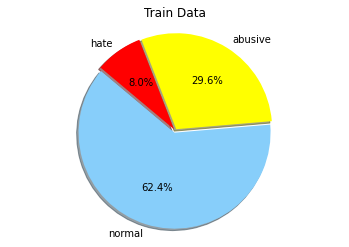

In [10]:
# Data to plot
labels = "normal", "abusive", "hate" 
sizes = [train_data['Class'].value_counts()[0], train_data['Class'].value_counts()[1], train_data['Class'].value_counts()[2]]
colors = ['lightskyblue', 'yellow', "red"]
explode = (0.02,0.02, 0.02) 

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title("Train Data")
plt.show()

# 2. Data Cleaning
To prepare our dataset for the feature extraction process, basic text preprocessing is done as follows:

In [11]:
def clean(df):
    df = remove_diacritics(df)
    df = normalize_arabic(df)
    df = remove_punctuations(df)
    df = remove_repeating_char(df)
    df= remove_english_word_and_numbers(df)
    df=clean_space(df)
    return df

In [12]:
arabic_punctuations = '''`÷« »×؛<>٩٨'٧٦٥٤٣٢١٠_()↗*•&^%][ـ،/:"؟.,'{}⋮≈~¦+|٪!”…“–ـ/[]%=#*+\\•~@£·_{}©^®`→°€™›♥←×§″′Â█à…“★”–●â►−¢¬░¶↑±▾	═¦║―¥▓—‹─▒：⊕▼▪†■’▀¨▄♫☆é¯♦¤▲è¸Ã⋅‘∞∙）↓、│（»，♪╩╚³・╦╣╔╗▬❤ïØ¹≤‡₹´'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

In [13]:
def remove_diacritics(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_diacritics(x))
    return df
def _remove_diacritics(x):
    x = str(x)
    x = re.sub(arabic_diacritics, '', x)
    return x

def normalize_arabic(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _normalize_arabic(x))
    return df
def _normalize_arabic(x):
    x = str(x)
    # added space around puncts after replace
    x = re.sub("[إأآا]", "ا", x)
    x = re.sub("ى", "ي", x)
    x = re.sub("ؤ", "ء", x)
    x = re.sub("ئ", "ء", x)
    x = re.sub("ة", "ه", x)
    x = re.sub("گ", "ك", x)
    return x

def remove_punctuations(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_punctuations(x))
    return df
def _remove_punctuations(x):
    x = str(x)
    #translator = str.maketrans(' ', ' ', punctuations_list)
    translator = str.maketrans(punctuations_list, ' '*len(punctuations_list))
    return x.translate(translator)

def remove_repeating_char(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_repeating_char(x))
    return df
def _remove_repeating_char(x):
    x = str(x)
    return re.sub(r'(.)\1+', r'\1', x)

def remove_english_word_and_numbers(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_english_word_and_numbers(x))
    return df
def _remove_english_word_and_numbers(x):
    x = str(x)
    return re.sub(r'[a-zA-Z0-9]+', '', x)

def clean_space(df):
    compiled_re = re.compile(r"\s+")
    df['Tweet'] = df["Tweet"].apply(lambda x: _clean_space(x, compiled_re))
    return df
def _clean_space(x, compiled_re):
    return compiled_re.sub(" ", x)


In [14]:
num_cores = 2
def df_parallelize_run(df, func, num_cores=2):
    df_split = np.array_split(df, num_cores)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [15]:
train_data_cleaned = df_parallelize_run(train_data, clean)

In [16]:
train_data_cleaned.to_csv("train_data_cleaned.csv", index=False)    #save the train_data_cleaned dataframe to csv

In [17]:
!cp -R train_data_cleaned.csv "/content/drive/My Drive/OSACT4"            #save the csv file to the drive

# 3. tf- idf
We experimented with various classical machine learning models:

1.  SVM
2.  Random Forest
3.  XGBoost
4.  Extra Trees
5.  Decision Trees
6.  Gradient Boosting
7.  Logistic Regression









In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [19]:
dataset = pd.read_csv('/content/drive/My Drive/OSACT4')

In [20]:
dataset.head()

,Tweet,Class
0,وزير الخارجيه البناني جبران باسيل قال في سلسله...,normal
1,سوريه بلد الحضارات تربطها بعليه او بحيوان,normal
2,اخي الحاج اذا شعرت انك محرجا من الانتقادات لتص...,normal
3,ما فيك تعيش بلا ما تكب فتن ليل نهار وبكره قلهم...,normal
4,هذا البطل الذي قاتل وجاذف بحياته لتحيا انت يا ...,abusive


In [21]:
x=dataset.iloc[:,0]
y=dataset.iloc[:,1]
X=x.to_dict()

X=[]
for d in range(len(x)):
    b=x[d]
    X.append(b) 

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
count_vect=CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf= X_train_tfidf.toarray()

In [24]:
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_test_tfidf= X_test_tfidf.toarray()

In [25]:
print(X_train_tfidf.shape, X_test_tfidf.shape)

(3740, 14122) (936, 14122)



## SVM Classifier

In [26]:
from sklearn.svm import SVC
clf= SVC(random_state = 0)
clf.fit(X_train_tfidf, y_train)
clf.score(X_train_tfidf, y_train)

0.975668449197861

In [27]:
y_pred = clf.predict(X_test_tfidf)

In [28]:
y_test

2493       hate
33       normal
3683    abusive
4129     normal
3193     normal
         ...   
3948     normal
1991       hate
3720     normal
356      normal
3837     normal
Name: Class, Length: 936, dtype: object

In [29]:
print(creport(y_test, y_pred, target_names=["normal", "abusive", "hate"], digits=4))

              precision    recall  f1-score   support

      normal     0.7688    0.4659    0.5802       264
     abusive     1.0000    0.0154    0.0303        65
        hate     0.7600    0.9703    0.8524       607

    accuracy                         0.7618       936
   macro avg     0.8429    0.4839    0.4876       936
weighted avg     0.7791    0.7618    0.7185       936



## Random Forest Classifier


In [30]:
from sklearn import model_selection, naive_bayes, svm, ensemble, tree
from xgboost import XGBClassifier

In [31]:
RF= ensemble.RandomForestClassifier()
RF.fit(X_train_tfidf, y_train)
RF.score(X_train_tfidf, y_train)

0.9991978609625668

In [32]:
y_pred=RF.predict(X_test_tfidf)

In [33]:
print(creport(y_test, y_pred, target_names=["normal", "abusive", "hate"], digits=4))

              precision    recall  f1-score   support

      normal     0.7340    0.5227    0.6106       264
     abusive     0.7778    0.1077    0.1892        65
        hate     0.7903    0.9621    0.8678       607

    accuracy                         0.7788       936
   macro avg     0.7674    0.5308    0.5559       936
weighted avg     0.7735    0.7788    0.7481       936



## XGB Classifier

In [34]:
XGB= XGBClassifier()
XGB.fit(X_train_tfidf, y_train)
XGB.score(X_train_tfidf, y_train)

0.753475935828877

In [35]:
y_pred=XGB.predict(X_test_tfidf)

In [36]:
print(creport(y_test, y_pred, target_names=["normal", "abusive", "hate"], digits=4))

              precision    recall  f1-score   support

      normal     0.8088    0.4167    0.5500       264
     abusive     0.7500    0.1385    0.2338        65
        hate     0.7538    0.9786    0.8516       607

    accuracy                         0.7618       936
   macro avg     0.7709    0.5112    0.5451       936
weighted avg     0.7691    0.7618    0.7236       936



##Extra Trees Classifier

In [37]:
extrees= ensemble.ExtraTreesClassifier()
extrees.fit(X_train_tfidf, y_train)
extrees.score(X_train_tfidf, y_train)

0.9991978609625668

In [38]:
y_pred=extrees.predict(X_test_tfidf)

In [39]:
print(creport(y_test, y_pred, target_names=["normal", "abusive", "hate"], digits=4))

              precision    recall  f1-score   support

      normal     0.7273    0.5455    0.6234       264
     abusive     0.7692    0.1538    0.2564        65
        hate     0.8028    0.9588    0.8739       607

    accuracy                         0.7863       936
   macro avg     0.7664    0.5527    0.5846       936
weighted avg     0.7791    0.7863    0.7603       936



## Decision Tree Classifier

In [40]:
DTC= tree.DecisionTreeClassifier()
DTC.fit(X_train_tfidf, y_train)
DTC.score(X_train_tfidf, y_train)

0.9991978609625668

In [41]:
y_pred=DTC.predict(X_test_tfidf)

In [42]:
print(creport(y_test, y_pred, target_names=["normal", "abusive", "hate"], digits=4))

              precision    recall  f1-score   support

      normal     0.5138    0.5644    0.5379       264
     abusive     0.3333    0.1846    0.2376        65
        hate     0.7885    0.7924    0.7905       607

    accuracy                         0.6859       936
   macro avg     0.5452    0.5138    0.5220       936
weighted avg     0.6794    0.6859    0.6808       936



## Gradient Boosting Classifier

In [43]:
GBC= ensemble.GradientBoostingClassifier()
GBC.fit(X_train_tfidf, y_train)
GBC.score(X_train_tfidf, y_train)

0.7909090909090909

In [44]:
y_pred=GBC.predict(X_test_tfidf)

In [45]:
print(creport(y_test, y_pred, target_names=["normal", "abusive", "hate"], digits=4))

              precision    recall  f1-score   support

      normal     0.7722    0.4621    0.5782       264
     abusive     0.6111    0.1692    0.2651        65
        hate     0.7737    0.9687    0.8603       607

    accuracy                         0.7703       936
   macro avg     0.7190    0.5334    0.5678       936
weighted avg     0.7620    0.7703    0.7394       936



## Logistic Regression Classifier

In [46]:
from sklearn import linear_model

In [47]:
LR= linear_model.LogisticRegression(multi_class='multinomial')
LR.fit(X_train_tfidf, y_train)
LR.score(X_train_tfidf, y_train)

0.8740641711229946

In [48]:
y_pred=LR.predict(X_test_tfidf)

In [49]:
print(creport(y_test, y_pred, target_names=["normal", "abusive", "hate"], digits=4))

              precision    recall  f1-score   support

      normal     0.7340    0.5227    0.6106       264
     abusive     0.7500    0.0462    0.0870        65
        hate     0.7809    0.9572    0.8601       607

    accuracy                         0.7714       936
   macro avg     0.7550    0.5087    0.5192       936
weighted avg     0.7655    0.7714    0.7360       936



In [50]:
print(X_test[444], y_pred[444])
print(X_test[123], y_pred[123])
print(X_test[666], y_pred[666])
print(X_test[58], y_pred[58])

كول هوا انت ودانيال abusive
ومش بس وءام كان عالباب وعون اسقبلهم والامير مجيذ الو مع اليهود جلسات حميمه وبحضور طلال  normal
كول هوا ولا abusive
عندما ياتي اليوم يحترم البنانين بعضهم البعضوعندما تستعمل المنصات لاغراض ايجابيه normal
